# Lecture 3
## Likelihoods & numerical minimizer fitting
_(Written by Jean-Loup Tastet, 2019-02-11)_

In [1]:
from __future__ import division # For those using Python 2, to avoid having 2/3==0.
from __future__ import print_function

## Exercise 2

In [2]:
import numpy as np
from numpy.random import rand, seed # Uniform RNG
import matplotlib.pyplot as plt
import matplotlib.colors # To create custom colormaps
from iminuit import Minuit # The Minuit minimizer, from the ROOT project

In [3]:
seed(42)

### Define the **normalized** PDF $f(x; \alpha, \beta)$ over $[-1, +1]$.

$$f(x; \alpha, \beta) = \frac{1 + \alpha x + \beta x^2}{2 + \frac{2}{3} \beta} \qquad x \in [-1, +1]$$

Properly normalized PDF, returning zero outside the allowed range.

In [4]:
def pdf(x, alpha, beta):
    in_interval = (x >= -1) & (x <= +1)
    # Value inside the interval. Outside, we return zero.
    val = (1 + alpha*x + beta*x**2) / (2 + (2/3)*beta)
    return np.where(in_interval, val, 0.)

Let's write a convenience function to create a PDF.

In [5]:
def make_pdf(alpha, beta):
    # Return a function depending only on x.
    return lambda x: pdf(x, alpha, beta)

In [6]:
true_alpha = 0.6
true_beta  = 0.5
f = make_pdf(true_alpha, true_beta)

### Sample from $f(x; \alpha, \beta)$ using Monte-Carlo rejection sampling.

We need to know an upper bound on $f(x; \alpha, \beta)$.

Here, we have an analytical value. If $\beta < 0$, it is located at $-\frac{\alpha}{2\beta}$, otherwise it is at one of the edges $x = \pm 1$.

In [7]:
def pdf_maximum(alpha, beta):
    f = make_pdf(alpha, beta)
    return f(-alpha/(2*beta)) if beta < 0 else max(f(-1), f(+1))

In [8]:
def sample(Npoints, interval, f, f_max, batchsize=None):
    if batchsize is None:
        batchsize = Npoints // 2 # Integer division
    xmin, xmax = interval
    x = np.zeros(Npoints)
    N = 0
    while N < Npoints:
        # Draw one batch of uniformly distributed points in [xmin, xmax]
        this_batch_size = min(batchsize, Npoints - N)
        batch = xmin + rand(this_batch_size) * (xmax-xmin)
        # Do rejection sampling for each point
        accepted = f(batch) > (rand(this_batch_size) * f_max)
        # Count the accepted points and add them to the output array
        N_accepted = np.sum(accepted)
        x[N:N+N_accepted] = batch[accepted]
        N += N_accepted
    return x

In [9]:
def sample_from_pdf(Npoints, alpha, beta, **kwargs):
    f = make_pdf(alpha, beta)
    f_max = pdf_maximum(alpha, beta)
    return sample(Npoints, (-1, +1), f, f_max, **kwargs)

### Check that our Monte-Carlo gives meaningful results

In [10]:
Npoints = 2000
data = sample_from_pdf(Npoints, true_alpha, true_beta)

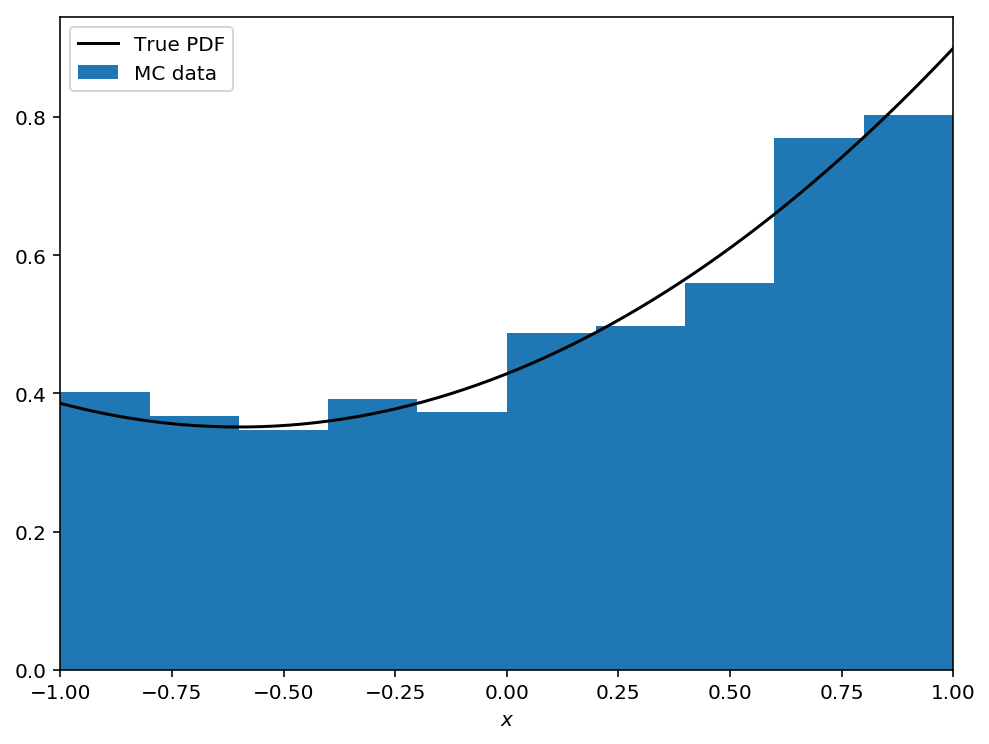

In [11]:
fig_mc_check, ax_mc_check = plt.subplots(figsize=(8,6))
x_range = np.linspace(-1, +1, 200)
ax_mc_check.plot(x_range, f(x_range), 'k-', label='True PDF')
# The `density=True` argument automatically normalizes the histogram
# so that it can be interpreted as a probability density.
ax_mc_check.hist(data, density=True, label='MC data')
ax_mc_check.set_xlabel('$x$')
ax_mc_check.legend()
ax_mc_check.autoscale(enable=True, axis='x', tight=True)

It seems to work!

### Maximum likelihood estimation

Generic log-likelihood definition.

In [12]:
def llh(data, pdf):
    return np.sum(np.log(pdf(data)), axis=0)

Make a target function $-2\mathrm{LLH}(\alpha, \beta)$ which only depends on $\alpha$ and $\beta$, and has a minimum where the likelihood has a maximum.

In [13]:
def make_target(data):
    return lambda alpha, beta: -2*llh(data, make_pdf(alpha, beta))

In [14]:
target = make_target(data)

Let's minimize!

In [15]:
minimizer = Minuit(target)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: Parameter alpha does not have initial value. Assume 0.
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: Parameter alpha is floating but does not have initial step size. Assume 1.
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: Parameter beta does not have initial value. Assume 0.
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: Parameter beta is floating but does not have initial step size. Assume 1.
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: errordef is not given. Default to 1.
  """Entry point for launching an IPython kernel.


In [16]:
minimizer.migrad()

FCN = 2596.7825517871224 
 TOTAL NCALL = 42 
 NCALLS = 42 
 
 
 EDM = 3.946446998385696e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.564506,0.0520685,,,,,No
1,beta,0.533814,0.103877,,,,,No


({'fval': 2596.7825517871224,
  'edm': 3.946446998385696e-06,
  'nfcn': 42,
  'up': 1.0,
  'is_valid': True,
  'has_valid_parameters': True,
  'has_accurate_covar': True,
  'has_posdef_covar': True,
  'has_made_posdef_covar': False,
  'hesse_failed': False,
  'has_covariance': True,
  'is_above_max_edm': False,
  'has_reached_call_limit': False},
 [{'number': 0,
   'name': 'alpha',
   'value': 0.5645058564291071,
   'error': 0.052068472299683415,
   'is_const': False,
   'is_fixed': False,
   'has_limits': False,
   'has_lower_limit': False,
   'has_upper_limit': False,
   'lower_limit': None,
   'upper_limit': None},
  {'number': 1,
   'name': 'beta',
   'value': 0.533814452696201,
   'error': 0.10387652244722304,
   'is_const': False,
   'is_fixed': False,
   'has_limits': False,
   'has_lower_limit': False,
   'has_upper_limit': False,
   'lower_limit': None,
   'upper_limit': None}])

In [17]:
print(minimizer.values)

<ValueView of Minuit at 5567744698c8>
  alpha: 0.5645058564291071
  beta: 0.533814452696201


And here is the maximum likelihood:

In [18]:
maxllh = -1/2 * minimizer.fval
print('Maximum likelihood LLH = {:.1f}'.format(maxllh))

Maximum likelihood LLH = -1298.4


And the parabolic error:

In [19]:
minimizer.hesse()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.564506,0.0520683,,,,,No
1,beta,0.533814,0.103876,,,,,No


+,alpha,beta
alpha,1.00,0.48
beta,0.48,1.00


[{'number': 0,
  'name': 'alpha',
  'value': 0.5645058564291071,
  'error': 0.052068327674719854,
  'is_const': False,
  'is_fixed': False,
  'has_limits': False,
  'has_lower_limit': False,
  'has_upper_limit': False,
  'lower_limit': None,
  'upper_limit': None},
 {'number': 1,
  'name': 'beta',
  'value': 0.533814452696201,
  'error': 0.10387619711317195,
  'is_const': False,
  'is_fixed': False,
  'has_limits': False,
  'has_lower_limit': False,
  'has_upper_limit': False,
  'lower_limit': None,
  'upper_limit': None}]

In [20]:
print(minimizer.errors)

<ErrorView of Minuit at 5567744698c8>
  alpha: 0.052068327674719854
  beta: 0.10387619711317195


## Exercise 3

### Likelihood landscape

In [21]:
alpha_range = np.linspace(-0.2, 1, num=100)
beta_range  = np.linspace(   0, 1, num=100)

In [22]:
aa, bb = np.meshgrid(alpha_range, beta_range, indexing='ij')
aaa = aa[np.newaxis,:,:]
bbb = bb[np.newaxis,:,:]
xxx = data[:,np.newaxis,np.newaxis]
ttt = make_target(xxx)

In [23]:
target_landscape = ttt(aa, bb)
llh_landscape = -1/2 * target_landscape

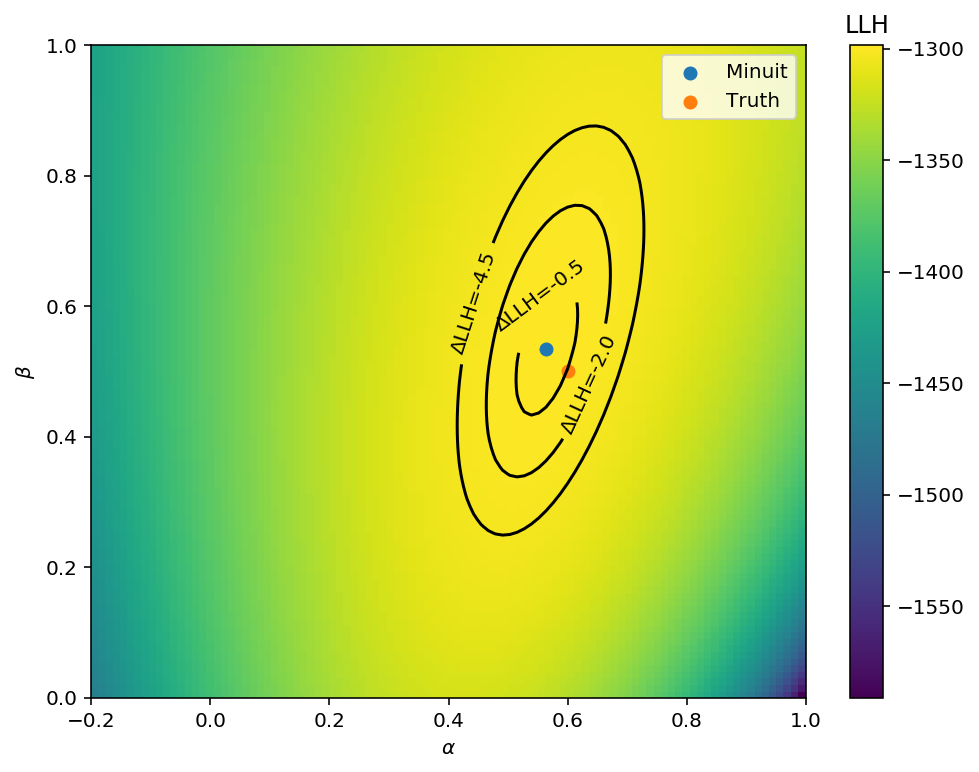

In [24]:
dllh = 1/2 * np.sort(np.array([-1, -4, -9]))
fig_landscape, ax_landscape = plt.subplots(figsize=(8,6))
plot_landscape = ax_landscape.pcolormesh(aa, bb, llh_landscape, label='LLH')
mval = minimizer.values
ax_landscape.scatter([mval['alpha']], [mval['beta']], label='Minuit')
ax_landscape.scatter([true_alpha], [true_beta], label='Truth')
iso = maxllh + dllh
# Hack to get black contours: create a uniform, black colormap.
black_cmap = matplotlib.colors.ListedColormap(['black'])
cs = ax_landscape.contour(aa, bb, llh_landscape, levels=iso, cmap=black_cmap)
def fmt(llh):
    return 'ΔLLH={:}'.format(llh-maxllh)
ax_landscape.clabel(cs, cs.levels, inline=True, fmt=fmt, colors='k')
ax_landscape.set_xlabel(r'$\alpha$')
ax_landscape.set_ylabel(r'$\beta$')
cbar_landscape = fig_landscape.colorbar(plot_landscape)
cbar_landscape.ax.set_title('LLH')
ax_landscape.legend()

How does the LLH landscape change when varying the true parameters $\alpha$ and $\beta$ or the number of points?